# Paper CHF - 8 beats

## Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from imblearn.metrics import classification_report_imbalanced

import time

In [2]:
THREADS_TO_USE = 4

In [3]:
def parse_accuracy_per_class(conf_matrix, classes):
    acc_per_class = dict()
    for i, c in enumerate(classes):
        tn, fp, fn, tp = conf_matrix[i].ravel()
        acc_per_class[c] = (tp + tn) /(tp + tn + fp + fn)
    return acc_per_class

## Load dataset

In [4]:
data = pd.read_csv('../dataset/st_dataset_8beats.csv')
data = data.dropna()
data.head()

,id,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,...,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16,label
0,e0106,30.571581,30.571114,30.597163,8.654545,1.254944,0.902949,-0.773465,-1.399254,-0.734867,...,-0.052333,0.042084,-0.051954,0.052820,-0.078516,0.018113,-0.033035,-0.008121,-0.004387,NSR
1,e0106,35.327463,37.090233,36.619925,10.318908,1.501561,0.936195,-0.694743,-1.301387,-0.880195,...,-0.025711,0.004880,-0.014158,0.033816,-0.052615,-0.010039,-0.020460,-0.003424,-0.010776,NSR
2,e0106,33.754220,34.253945,34.112950,9.653801,1.420377,0.922050,-0.707779,-1.271389,-0.778260,...,-0.041095,0.024671,-0.028207,0.045623,-0.069928,-0.007982,-0.010177,-0.011244,-0.007525,NSR
3,e0106,33.428166,32.277378,32.154651,9.225828,1.332695,0.898518,-0.728415,-1.302251,-0.708089,...,-0.053417,0.034100,-0.041100,0.034451,-0.060591,-0.005673,-0.010582,-0.020471,0.001472,NSR
4,e0106,34.438584,33.565638,33.382364,9.589036,1.426830,0.886530,-0.727896,-1.310174,-0.910833,...,-0.077430,0.064301,-0.063539,0.066193,-0.087852,0.018333,-0.028678,-0.022301,0.009486,NSR


In [5]:
data['label'].value_counts()

NSR    52426
ST-    10993
ST+     4936
Name: label, dtype: int64

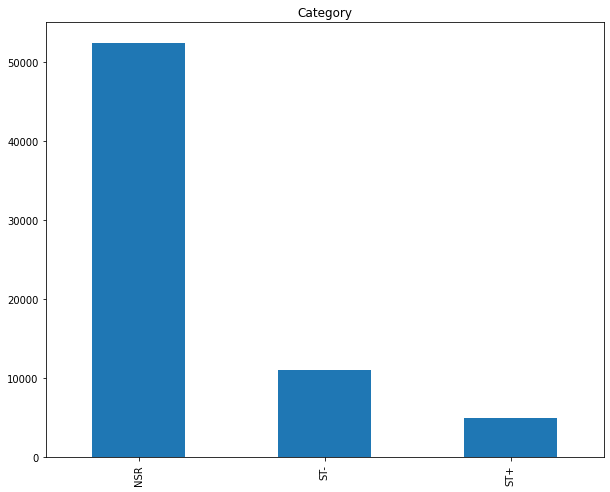

In [6]:
data['label'].value_counts().plot(kind='bar', title='Category', figsize=(10,8))
plt.show()

In [7]:
data.corr()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,mfw_5,...,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16
dw_1,1.000000,0.232673,0.111713,0.079107,0.076764,0.077147,-0.018860,0.030559,0.040220,-0.014666,...,-0.053028,-0.055461,-0.025675,-0.018685,-0.009704,-0.039241,-0.027948,-0.044903,-0.065581,-0.044688
dw_2,0.232673,1.000000,0.839282,0.452814,0.160598,0.424152,-0.484394,-0.404156,0.100065,0.435652,...,-0.136686,0.140104,0.232989,0.166906,0.045325,0.029218,0.115506,-0.000752,-0.115788,-0.079295
dw_3,0.111713,0.839282,1.000000,0.631576,0.240584,0.301445,-0.535593,-0.534332,-0.030329,0.564342,...,-0.206789,0.121560,0.266346,0.117884,-0.049549,0.051187,0.045371,-0.026800,-0.130477,-0.049044
dw_4,0.079107,0.452814,0.631576,1.000000,0.895025,0.016860,-0.237619,-0.260776,-0.029358,0.299563,...,-0.147248,0.048851,0.116574,0.042862,-0.044403,0.042171,0.026140,-0.032931,-0.089245,-0.033579
dw_5,0.076764,0.160598,0.240584,0.895025,1.000000,-0.105960,-0.011988,-0.035024,-0.012480,0.061799,...,-0.066765,0.004155,0.014207,0.013282,-0.012686,0.016035,0.013783,-0.034165,-0.041855,-0.018000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfr_12,-0.039241,0.029218,0.051187,0.042171,0.016035,-0.094790,0.068312,0.129263,0.122377,-0.090957,...,-0.127261,-0.207625,-0.097674,0.019114,0.057081,1.000000,0.003281,-0.017734,-0.318789,-0.208539
cfr_13,-0.027948,0.115506,0.045371,0.026140,0.013783,0.077604,-0.004769,0.006963,0.049874,0.008203,...,0.128357,0.032112,-0.217503,-0.271096,-0.046139,0.003281,1.000000,0.186633,0.097077,-0.171867
cfr_14,-0.044903,-0.000752,-0.026800,-0.032931,-0.034165,0.032269,0.017775,0.034991,0.012523,-0.020623,...,0.096622,0.214725,0.044225,-0.177405,-0.291133,-0.017734,0.186633,1.000000,0.157260,-0.146906
cfr_15,-0.065581,-0.115788,-0.130477,-0.089245,-0.041855,0.009040,0.083235,0.080419,-0.058850,-0.098386,...,0.258472,0.163393,-0.078272,-0.146256,-0.095566,-0.318789,0.097077,0.157260,1.000000,0.229510


In [8]:
y = data['label'].values
X = data.loc[:, ~data.columns.isin(["id", "label"])].copy()
patient_ids = data["id"].values

In [9]:
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

## Feature selection

### exclude features with corr > 0.95

In [10]:
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [11]:
print(correlated_features)

{'fft_149', 'fft_202', 'fft_157', 'fft_240', 'fft_203', 'fft_168', 'fft_252', 'fft_137', 'fft_160', 'fft_233', 'fft_193', 'fft_131', 'fft_237', 'fft_175', 'fft_217', 'fft_197', 'fft_225', 'fft_195', 'fft_201', 'fft_230', 'fft_242', 'fft_187', 'fft_231', 'fft_139', 'fft_172', 'fft_210', 'fft_204', 'fft_245', 'fft_208', 'fft_211', 'fft_166', 'fft_156', 'fft_246', 'fft_145', 'fft_255', 'fft_173', 'fft_214', 'fft_253', 'fft_180', 'fft_184', 'fft_171', 'fft_179', 'fft_241', 'fft_147', 'fft_239', 'fft_192', 'fft_162', 'fft_232', 'fft_218', 'fft_207', 'fft_155', 'fft_188', 'fft_191', 'fft_199', 'fft_196', 'fft_194', 'fft_161', 'fft_136', 'fft_158', 'fft_178', 'fft_228', 'fft_229', 'fft_244', 'fft_159', 'fft_163', 'fft_254', 'fft_130', 'fft_138', 'fft_216', 'mfw_11', 'fft_251', 'fft_219', 'fft_215', 'fft_177', 'fft_205', 'fft_256', 'fft_213', 'fft_141', 'fft_167', 'fft_234', 'fft_206', 'fft_134', 'fft_183', 'fft_144', 'fft_190', 'fft_170', 'fft_198', 'fft_150', 'fft_221', 'fft_182', 'fft_143',

### Random forest embeded for features selection

In [12]:
cols_no_corr = [col for col in X.columns if col not in correlated_features]

In [13]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE), threshold='1.25*median')
embeded_rf_selector.fit(X[cols_no_corr], y)

SelectFromModel(estimator=RandomForestClassifier(n_jobs=4, random_state=101),
                threshold='1.25*median')

In [14]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X[cols_no_corr].loc[:,embeded_rf_support].columns.tolist()

print('\n'.join(embeded_rf_feature), '\nselected features:', len(embeded_rf_feature))

dw_1
dw_2
dw_3
dw_4
dw_5
mfw_1
mfw_2
mfw_3
mfw_4
mfw_5
mfw_6
mfw_7
mfw_8
mfw_9
mfw_10
mfw_12
mfw_13
mfw_14
mfw_15
mfw_16
fft_1
fft_2
fft_3
fft_4
fft_5
fft_6
fft_7
fft_8
fft_9
fft_10
fft_11
fft_12
fft_13
fft_14
fft_15
fft_16
fft_17
fft_20
fft_21
fft_22
fft_23
fft_24
fft_29
fft_30
fft_31
fft_32
fft_33
fft_34
fft_35
fft_36
ar_1
ar_2
ar_3
ar_4
ar_5
ar_6
ar_7
ar_8
ar_9
ar_10
ar_12
ar_15
ar_16
var
cfr_1
cfr_2
cfr_3
cfr_4
cfr_5
cfr_6
cfr_7
cfr_8
cfr_9
cfr_10
cfr_11
cfr_12
cfr_13
cfr_14
cfr_15 
selected features: 79


### Visualization best features

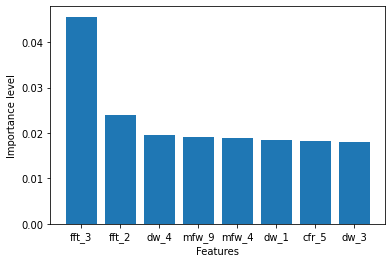

In [15]:
features_dict = dict(zip(cols_no_corr, embeded_rf_selector.estimator_.feature_importances_))
features_dict = dict(sorted(features_dict.items(), key=lambda item: item[1], reverse=True))

best_features = dict()
for index, (key, value) in enumerate(features_dict.items()):
    if index < 8:
        best_features[key] = value

plt.bar(range(len(best_features)), list(best_features.values()), align='center', )
plt.xticks(ticks=range(len(best_features)), labels=best_features.keys())
plt.xlabel('Features')
plt.ylabel('Importance level')
plt.show()

## Filter features

In [16]:
X_fsel = X[embeded_rf_feature]
X_fsel.head()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,mfw_5,...,cfr_6,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15
0,30.571581,30.571114,30.597163,8.654545,1.254944,0.902949,-0.773465,-1.399254,-0.734867,12.762118,...,0.012196,0.047766,-0.052333,0.042084,-0.051954,0.052820,-0.078516,0.018113,-0.033035,-0.008121
1,35.327463,37.090233,36.619925,10.318908,1.501561,0.936195,-0.694743,-1.301387,-0.880195,10.573212,...,0.022624,0.032716,-0.025711,0.004880,-0.014158,0.033816,-0.052615,-0.010039,-0.020460,-0.003424
2,33.754220,34.253945,34.112950,9.653801,1.420377,0.922050,-0.707779,-1.271389,-0.778260,10.515795,...,0.010279,0.036796,-0.041095,0.024671,-0.028207,0.045623,-0.069928,-0.007982,-0.010177,-0.011244
3,33.428166,32.277378,32.154651,9.225828,1.332695,0.898518,-0.728415,-1.302251,-0.708089,11.496901,...,0.005352,0.048697,-0.053417,0.034100,-0.041100,0.034451,-0.060591,-0.005673,-0.010582,-0.020471
4,34.438584,33.565638,33.382364,9.589036,1.426830,0.886530,-0.727896,-1.310174,-0.910833,10.732432,...,-0.003147,0.052752,-0.077430,0.064301,-0.063539,0.066193,-0.087852,0.018333,-0.028678,-0.022301


## Random Forest - L1SO

In [17]:
cvds = X_fsel.copy()
cvds["patient_id"] = patient_ids
cvds["label"] = y

patients = np.unique(cvds["patient_id"].values)
patients

array(['e0106', 'e0110', 'e0115', 'e0129', 'e0133', 'e0151', 'e0202',
       'e0203', 'e0204', 'e0205', 'e0206', 'e0207', 'e0208', 'e0210',
       'e0211', 'e0212', 'e0213', 'e0302', 'e0303', 'e0304', 'e0305',
       'e0306', 'e0403', 'e0404', 'e0405', 'e0406', 'e0408', 'e0409',
       'e0410', 'e0411', 'e0413', 'e0415', 'e0417', 'e0418', 'e0515',
       'e0601', 'e0602', 'e0603', 'e0605', 'e0606', 'e0607', 'e0609',
       'e0610', 'e0611', 'e0612', 'e0613', 'e0614', 'e0615', 'e0704',
       'e0801', 'e0808', 'e0817', 'e0818', 'e1301', 'e1302', 'e1304'],
      dtype=object)

In [18]:
classes = np.unique(label_encoder.inverse_transform(y))

In [19]:
result_df = pd.DataFrame()
tot = len(patients)
for i, patient in enumerate(patients):
    start_time = time.time()

    # Train and Test split
    df1 = cvds.loc[cvds["patient_id"] != patient]
    df2 = cvds.loc[cvds["patient_id"] == patient]

    y_train = df1["label"].values
    x_train = df1.loc[:, ~df1.columns.isin(['patient_id', 'label'])]
    y_test = df2["label"].values
    x_test = df2.loc[:, ~df2.columns.isin(['patient_id', 'label'])]

    # Training
    model = RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE).fit(x_train, y_train)

    # Prediction
    y_pred = model.predict(x_test)

    # Decode
    y_test_dec = label_encoder.inverse_transform(y_test)
    y_pred_dec = label_encoder.inverse_transform(y_pred)

    # get metrics
    report = classification_report_imbalanced(y_true=y_test_dec, y_pred=y_pred_dec, labels=label_encoder.classes_, zero_division=1, output_dict=True)
    confusion_matrix = multilabel_confusion_matrix(y_pred=y_pred_dec, y_true=y_test_dec, labels=classes)

    # TOTAL
    tot_accuracy    = accuracy_score(y_true=y_test_dec, y_pred=y_pred_dec)
    tot_precision   = report['avg_pre']
    tot_recall      = report['avg_rec']
    tot_specificity = report['avg_spe']
    tot_f1          = report['avg_f1']

    # NSR
    nsr_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['NSR']
    nsr_precision   = report['NSR']['pre']
    nsr_recall      = report['NSR']['rec']
    nsr_specificity = report['NSR']['spe']
    nsr_f1          = report['NSR']['f1']

    # ST+
    st1_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st1_precision   = report['ST+']['pre']
    st1_recall      = report['ST+']['rec']
    st1_specificity = report['ST+']['spe']
    st1_f1          = report['ST+']['f1']

    # ST-
    st0_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st0_precision   = report['ST-']['pre']
    st0_recall      = report['ST-']['rec']
    st0_specificity = report['ST-']['spe']
    st0_f1          = report['ST-']['f1']

    # save result in result_df
    result_df = result_df.append({
        "accuracy": tot_accuracy,
        "precision": tot_precision,
        "recall": tot_recall,
        "specificity": tot_specificity,
        "f1": tot_f1,

        "nsr_accuracy": nsr_accuracy,
        "nsr_precision": nsr_precision,
        "nsr_recall": nsr_recall,
        "nsr_specificity": nsr_specificity,
        "nsr_f1": nsr_f1,

        "st+_accuracy": st1_accuracy,
        "st+_precision": st1_precision,
        "st+_recall": st1_recall,
        "st+_specificity": st1_specificity,
        "st+_f1": st1_f1,

        "st-_accuracy": st0_accuracy,
        "st-_precision": st0_precision,
        "st-_recall": st0_recall,
        "st-_specificity": st0_specificity,
        "st-_f1": st0_f1,
    }, ignore_index=True)
    end_time = time.time()

    elapsed_seconds = end_time - start_time
    # Log result
    print("#---------------------#")
    print(i+1, "of", len(patients), "-", elapsed_seconds, "s")
    print("Tot: Accuracy", tot_accuracy, "Precision", tot_precision, "Recall", tot_recall, "Specificity", tot_specificity, "F1", tot_f1)
    print("NSR: Accuracy", nsr_accuracy, "Precision", nsr_precision, "Recall", nsr_recall, "Specificity", nsr_specificity, "F1", nsr_f1)
    print("ST+: Accuracy", st1_accuracy, "Precision", st1_precision, "Recall", st1_recall, "Specificity", st1_specificity, "F1", st1_f1)
    print("ST-: Accuracy", st0_accuracy, "precision", st0_precision, "Recall", st0_recall, "Specificity", st0_specificity, "F1", st0_f1)
    print("#---------------------#")

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
1 of 56 - 19.200919151306152 s
Tot: Accuracy 0.8215077605321508 Precision 0.8533672400823988 Recall 0.8215077605321508 Specificity 0.17849223946784923 F1 0.7410070000661275
NSR: Accuracy 0.8215077605321508 Precision 0.8215077605321508 Recall 1.0 Specificity 0.0 F1 0.9020085209981741
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
2 of 56 - 19.314194202423096 s
Tot: Accuracy 0.8024830699774267 Precision 0.8414960076229687 Recall 0.8024830699774267 Specificity 0.19751693002257337 F1 0.7145466033236699
NSR: Accuracy 0.8024830699774267 Precision 0.8024830699774267 Recall 1.0 Specificity 0.0 F1 0.8904195366311836
ST+: Accuracy 0.8024830699774267 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.8024830699774267 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
3 of 56 - 19.631556510925293 s
Tot: Accuracy 0.9204225352112676 Precision 0.9005446937091852 Recall 0.9204225352112676 Specificity 0.0963556276537817 F1 0.8842961930836221
NSR: Accuracy 0.9204225352112676 Precision 0.9209597741707833 Recall 0.9992343032159265 Specificity 0.017543859649122806 F1 0.9585016525890563
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.6666666666666666 Recall 0.017543859649122806 Specificity 0.9992343032159265 F1 0.03418803418803419
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
4 of 56 - 19.2390034198761 s
Tot: Accuracy 0.8643356643356643 Precision 0.8827404763069099 Recall 0.8643356643356643 Specificity 0.13566433566433567 F1 0.8014395207193407
NSR: Accuracy 0.8643356643356643 Precision 0.8643356643356643 Recall 1.0 Specificity 0.0 F1 0.927231807951988
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
5 of 56 - 19.225332021713257 s
Tot: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 0.0 F1 1.0
NSR: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 0.0 F1 1.0
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
6 of 56 - 19.384521961212158 s
Tot: Accuracy 0.9989583333333333 Precision 1.0 Recall 0.9989583333333333 Specificity 0.0 F1 0.9994788952579466
NSR: Accuracy 0.9989583333333333 Precision 1.0 Recall 0.9989583333333333 Specificity 0.0 F1 0.9994788952579468
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.9989583333333333 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
7 of 56 - 19.966362953186035 s
Tot: Accuracy 0.7200956937799043 Precision 0.7989451411982459 Recall 0.7200956937799043 Specificity 0.3021884287827698 F1 0.609189044456845
NSR: Accuracy 0.7200956937799043 Precision 0.7182985553772071 Recall 1.0 Specificity 0.022284122562674095 F1 0.8360579168612797
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.022284122562674095 Specificity 1.0 F1 0.043596730245231606
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
8 of 56 - 19.6397385597229 s
Tot: Accuracy 0.7895148669796557 Precision 0.7994368582835276 Recall 0.7895148669796557 Specificity 0.42956865527001953 F1 0.7421347663768363
NSR: Accuracy 0.7895148669796557 Precision 0.7856540084388186 Recall 0.9841437632135307 Specificity 0.23493975903614459 F1 0.8737681839511967
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.8387096774193549 Recall 0.23493975903614459 Specificity 0.9841437632135307 F1 0.36705882352941177
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
9 of 56 - 19.28006100654602 s
Tot: Accuracy 0.8364389233954451 Precision 0.9826721622717459 Recall 0.8364389233954451 Specificity 0.6862331413818828 F1 0.8994201043276541
NSR: Accuracy 0.8364389233954451 Precision 0.9950207468879668 Recall 0.8384615384615385 Specificity 0.6842105263157895 F1 0.9100569259962048
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.05327868852459016 Recall 0.6842105263157895 Specificity 0.8384615384615385 F1 0.09885931558935361
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
10 of 56 - 19.040826559066772 s
Tot: Accuracy 0.6507620941020543 Precision 0.7727292090180367 Recall 0.6507620941020543 Specificity 0.3492379058979457 F1 0.5130858100427277
NSR: Accuracy 0.6507620941020543 Precision 0.6507620941020543 Recall 1.0 Specificity 0.0 F1 0.788438378161381
ST+: Accuracy 0.6507620941020543 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.6507620941020543 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
11 of 56 - 19.09766435623169 s
Tot: Accuracy 0.7790697674418605 Precision 0.751274489141245 Recall 0.7790697674418605 Specificity 0.3271959820950886 F1 0.7204416225768486
NSR: Accuracy 0.7790697674418605 Precision 0.7886676875957122 Recall 0.9735349716446124 Specificity 0.1320754716981132 F1 0.871404399323181
ST+: Accuracy 0.9978197674418605 Precision 0.0 Recall 1.0 Specificity 0.9978197674418605 F1 0.0
ST-: Accuracy 0.9978197674418605 precision 0.6268656716417911 Recall 0.1320754716981132 Specificity 0.9763705103969754 F1 0.2181818181818182
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
12 of 56 - 18.66085410118103 s
Tot: Accuracy 0.7571743929359823 Precision 0.816138668381991 Recall 0.7571743929359823 Specificity 0.24282560706401765 F1 0.652539740645834
NSR: Accuracy 0.7571743929359823 Precision 0.7571743929359823 Recall 1.0 Specificity 0.0 F1 0.8618090452261306
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
13 of 56 - 19.361066102981567 s
Tot: Accuracy 0.9038984587488668 Precision 0.91313396497971 Recall 0.9038984587488668 Specificity 0.09610154125113328 F1 0.858273107973924
NSR: Accuracy 0.9038984587488668 Precision 0.9038984587488668 Recall 1.0 Specificity 0.0 F1 0.9495238095238095
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
14 of 56 - 19.873725652694702 s
Tot: Accuracy 0.81 Precision 0.8461000000000001 Recall 0.81 Specificity 0.19 F1 0.7249723756906078
NSR: Accuracy 0.81 Precision 0.81 Recall 1.0 Specificity 0.0 F1 0.8950276243093923
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
15 of 56 - 19.074950218200684 s
Tot: Accuracy 0.7337559429477021 Precision 0.6636270799314566 Recall 0.7337559429477021 Specificity 0.17037116954738515 F1 0.69646753112696
NSR: Accuracy 0.7337559429477021 Precision 0.8042973286875726 Recall 0.8923969072164949 Specificity 0.011730205278592375 F1 0.8460598656078192
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.023391812865497075 Recall 0.011730205278592375 Specificity 0.8923969072164949 F1 0.015624999999999997
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
16 of 56 - 18.339646339416504 s
Tot: Accuracy 0.9474068663257852 Precision 0.9501729040354591 Recall 0.9474068663257852 Specificity 0.052593133674214754 F1 0.9218204843394924
NSR: Accuracy 0.9474068663257852 Precision 0.9474068663257852 Recall 1.0 Specificity 0.0 F1 0.9729932483120779
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
17 of 56 - 19.4325168132782 s
Tot: Accuracy 0.7521306818181818 Precision 0.7624346540964656 Recall 0.7521306818181818 Specificity 0.41211333222465674 F1 0.6911988266972962
NSR: Accuracy 0.7521306818181818 Precision 0.7490494296577946 Recall 0.9810756972111554 Specificity 0.18316831683168316 F1 0.8495040965933591
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.7956989247311828 Recall 0.18316831683168316 Specificity 0.9810756972111554 F1 0.2977867203219316
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
18 of 56 - 18.744248628616333 s
Tot: Accuracy 0.969313387034906 Precision 0.9702550552501754 Recall 0.969313387034906 Specificity 0.03068661296509398 F1 0.9542091659669683
NSR: Accuracy 0.969313387034906 Precision 0.969313387034906 Recall 1.0 Specificity 0.0 F1 0.9844176081028437
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
19 of 56 - 18.502317190170288 s
Tot: Accuracy 0.8570151921358355 Precision 0.7373246191965426 Recall 0.8570151921358355 Specificity 0.14090364241151096 F1 0.7926771892613456
NSR: Accuracy 0.8570151921358355 Precision 0.8585496866606983 Recall 0.9979188345473465 Specificity 0.0 F1 0.9230028873917229
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 0.0 Specificity 0.9979188345473465 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
20 of 56 - 18.049628734588623 s
Tot: Accuracy 0.9880725190839694 Precision 0.9791029166651471 Recall 0.9880725190839694 Specificity 0.010481000684593698 F1 0.9835672688169678
NSR: Accuracy 0.9880725190839694 Precision 0.9894887720974678 Recall 0.9985535197685632 Specificity 0.0 F1 0.994000479961603
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 0.0 Specificity 0.9985535197685632 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
21 of 56 - 19.00352168083191 s
Tot: Accuracy 0.8184873949579832 Precision 0.8516011810129457 Recall 0.8184873949579832 Specificity 0.20853963206904383 F1 0.7416171085926055
NSR: Accuracy 0.8184873949579832 Precision 0.8175675675675675 Recall 1.0 Specificity 0.02702702702702703 F1 0.8996282527881041
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.02702702702702703 Specificity 1.0 F1 0.052631578947368425
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
22 of 56 - 18.425182104110718 s
Tot: Accuracy 0.6733466933867736 Precision 0.7800490761081281 Recall 0.6733466933867736 Specificity 0.32665330661322645 F1 0.5419029676118705
NSR: Accuracy 0.6733466933867736 Precision 0.6733466933867736 Recall 1.0 Specificity 0.0 F1 0.8047904191616767
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
23 of 56 - 18.10304880142212 s
Tot: Accuracy 0.3581833761782348 Precision 0.68478570380884 Recall 0.3581833761782348 Specificity 0.6746865696126424 F1 0.23462384023591304
NSR: Accuracy 0.3607540702656384 Precision 0.3387387387387387 Recall 0.9690721649484536 Specificity 0.057766367137355584 F1 0.5020026702269693
ST+: Accuracy 0.36246786632390743 Precision 0.8571428571428571 Recall 0.05391527599486521 Specificity 0.9819587628865979 F1 0.10144927536231883
ST-: Accuracy 0.36246786632390743 precision 0.0 Recall 1.0 Specificity 0.9931448157669237 F1 0.0
#---------------------#
#---------------------#
24 of 56 - 18.929972171783447 s
Tot: Accuracy 0.8458904109589042 Precision 0.8696401763933196 Recall 0.8458904109589042 Specificity 0.1541095890410959 F1 0.775268762548606
NSR: Accuracy 0.8458904109589042 Precision 0.8458904109589042 Recall 1.0 Specificity 0.0 F1 0.9165120593692023
ST+: Accuracy 0.908675799086758 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accur

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
25 of 56 - 19.210137605667114 s
Tot: Accuracy 0.7073518915060671 Precision 0.775625600360569 Recall 0.7073518915060671 Specificity 0.3870511893668469 F1 0.6143047535132202
NSR: Accuracy 0.7073518915060671 Precision 0.6994091580502215 Recall 0.9968421052631579 Specificity 0.0975609756097561 F1 0.8220486111111112
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.9361702127659575 Recall 0.0975609756097561 Specificity 0.9968421052631579 F1 0.17670682730923695
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
26 of 56 - 18.527838230133057 s
Tot: Accuracy 0.7122683142100618 Precision 0.5337195393224178 Recall 0.7122683142100618 Specificity 0.26622822809426855 F1 0.6102009990809911
NSR: Accuracy 0.7122683142100618 Precision 0.7276825969341749 Recall 0.9711191335740073 Specificity 0.0 F1 0.8319587628865979
ST+: Accuracy 0.9796999117387467 Precision 0.0 Recall 1.0 Specificity 0.9796999117387467 F1 0.0
ST-: Accuracy 0.9796999117387467 precision 0.0 Recall 0.0 Specificity 0.9987966305655837 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
27 of 56 - 18.86304998397827 s
Tot: Accuracy 0.8325991189427313 Precision 0.8616419390477659 Recall 0.8325991189427313 Specificity 0.3773134016520237 F1 0.8465256317531287
NSR: Accuracy 0.8325991189427313 Precision 0.9247967479674797 Recall 0.8869395711500975 Specificity 0.3211009174311927 F1 0.9054726368159205
ST+: Accuracy 0.9823788546255506 Precision 0.0 Recall 1.0 Specificity 0.9823788546255506 F1 0.0
ST-: Accuracy 0.9823788546255506 precision 0.26717557251908397 Recall 0.3211009174311927 Specificity 0.9064327485380117 F1 0.2916666666666667
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
28 of 56 - 18.6677508354187 s
Tot: Accuracy 0.5192307692307693 Precision 0.9552032192920638 Recall 0.5192307692307693 Specificity 0.9755122620787667 F1 0.6408631929341565
NSR: Accuracy 0.5204714640198511 Precision 0.08591885441527446 Recall 0.9113924050632911 Specificity 0.5003261578604045 F1 0.1570338058887677
ST+: Accuracy 0.9944168734491315 Precision 0.0 Recall 1.0 Specificity 0.9944168734491315 F1 0.0
ST-: Accuracy 0.9944168734491315 precision 1.0 Recall 0.49902152641878667 Specificity 1.0 F1 0.6657963446475196
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
29 of 56 - 18.741966724395752 s
Tot: Accuracy 0.14436248682824027 Precision 0.8764780407749937 Recall 0.14436248682824027 Specificity 0.8556375131717597 F1 0.03642294787379174
NSR: Accuracy 0.14436248682824027 Precision 0.14436248682824027 Recall 1.0 Specificity 0.0 F1 0.2523020257826888
ST+: Accuracy 0.14436248682824027 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.14436248682824027 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
30 of 56 - 18.20684266090393 s
Tot: Accuracy 0.9154030327214685 Precision 0.9306264964086194 Recall 0.9154030327214685 Specificity 0.08486016539029734 F1 0.8844953021460459
NSR: Accuracy 0.9162011173184358 Precision 0.925 Recall 0.9896462467644521 Specificity 0.010638297872340425 F1 0.9562317632346811
ST+: Accuracy 0.9896249002394254 Precision 0.0 Recall 1.0 Specificity 0.9896249002394254 F1 0.0
ST-: Accuracy 0.9896249002394254 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
31 of 56 - 18.62380838394165 s
Tot: Accuracy 0.9083820662768031 Precision 0.8935552556605189 Recall 0.9083820662768031 Specificity 0.37012218834164345 F1 0.893769479460093
NSR: Accuracy 0.9083820662768031 Precision 0.9230769230769231 Recall 0.9793253536452666 Specificity 0.29906542056074764 F1 0.9503695881731785
ST+: Accuracy 0.9990253411306043 Precision 0.0 Recall 1.0 Specificity 0.9990253411306043 F1 0.0
ST-: Accuracy 0.9990253411306043 precision 0.64 Recall 0.29906542056074764 Specificity 0.9804134929270947 F1 0.40764331210191085
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
32 of 56 - 18.22148823738098 s
Tot: Accuracy 0.5899524779361847 Precision 0.7788683462249295 Recall 0.5899524779361847 Specificity 0.6215357727165568 F1 0.5178751804492531
NSR: Accuracy 0.5899524779361847 Precision 0.5392829900839055 Recall 1.0 Specificity 0.21148825065274152 F1 0.7006937561942517
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.21148825065274152 Specificity 1.0 F1 0.34913793103448276
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
33 of 56 - 18.03400158882141 s
Tot: Accuracy 0.8478824546240277 Precision 0.8710422193179473 Recall 0.8478824546240277 Specificity 0.15776726289009663 F1 0.7789452898656282
NSR: Accuracy 0.8478824546240277 Precision 0.8477508650519031 Recall 1.0 Specificity 0.005649717514124294 F1 0.9176029962546817
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.005649717514124294 Specificity 1.0 F1 0.011235955056179775
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
34 of 56 - 18.652127265930176 s
Tot: Accuracy 0.5245231607629428 Precision 0.9378445017760437 Recall 0.5245231607629428 Specificity 0.9278290334827756 F1 0.6316480986426799
NSR: Accuracy 0.5245231607629428 Precision 0.9941520467836257 Recall 0.4949053857350801 Specificity 0.9574468085106383 F1 0.6608357628765792
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.11479591836734694 Recall 0.9574468085106383 Specificity 0.4949053857350801 F1 0.2050113895216401
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
35 of 56 - 18.301564931869507 s
Tot: Accuracy 0.9480994152046783 Precision 0.9507930859067748 Recall 0.9480994152046783 Specificity 0.051900584795321635 F1 0.9228404814412516
NSR: Accuracy 0.9480994152046783 Precision 0.9480994152046783 Recall 1.0 Specificity 0.0 F1 0.9733583489681051
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
36 of 56 - 18.25566601753235 s
Tot: Accuracy 0.98125 Precision 1.0 Recall 0.98125 Specificity 0.0 F1 0.9905362776025236
NSR: Accuracy 0.98125 Precision 1.0 Recall 0.98125 Specificity 0.0 F1 0.9905362776025236
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.98125 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
37 of 56 - 18.45878005027771 s
Tot: Accuracy 0.8818505338078292 Precision 0.8501466277218619 Recall 0.8818505338078292 Specificity 0.24731670103840322 F1 0.861188176338151
NSR: Accuracy 0.8825622775800712 Precision 0.9081404032860344 Recall 0.9666136724960255 Specificity 0.16326530612244897 F1 0.9364651520985753
ST+: Accuracy 0.999288256227758 Precision 0.0 Recall 1.0 Specificity 0.999288256227758 F1 0.0
ST-: Accuracy 0.999288256227758 precision 0.35384615384615387 Recall 0.1564625850340136 Specificity 0.9666136724960255 F1 0.2169811320754717
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
38 of 56 - 18.361127138137817 s
Tot: Accuracy 0.049 Precision 0.9552156469408225 Recall 0.049 Specificity 0.9531479538300105 F1 0.00822342380293274
NSR: Accuracy 0.05 Precision 0.04714142427281846 Recall 1.0 Specificity 0.0031479538300104933 F1 0.09003831417624521
ST+: Accuracy 0.049 Precision 1.0 Recall 0.002098635886673662 Specificity 1.0 F1 0.00418848167539267
ST-: Accuracy 0.049 precision 0.0 Recall 1.0 Specificity 0.999 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
39 of 56 - 18.634549617767334 s
Tot: Accuracy 0.8457337883959044 Precision 0.8389063814659025 Recall 0.8457337883959044 Specificity 0.616581695902469 F1 0.8344779493619244
NSR: Accuracy 0.8457337883959044 Precision 0.8610885458976442 Recall 0.9506726457399103 Specificity 0.5114285714285715 F1 0.9036658141517476
ST+: Accuracy 0.9993174061433447 Precision 0.0 Recall 1.0 Specificity 0.9993174061433447 F1 0.0
ST-: Accuracy 0.9993174061433447 precision 0.7682403433476395 Recall 0.5114285714285715 Specificity 0.9515695067264573 F1 0.614065180102916
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
40 of 56 - 18.70583438873291 s
Tot: Accuracy 0.8934426229508197 Precision 0.896520711288526 Recall 0.8934426229508197 Specificity 0.5713795114365322 F1 0.8791478551543274
NSR: Accuracy 0.8934426229508197 Precision 0.8901996370235935 Recall 0.990909090909091 Specificity 0.47391304347826085 F1 0.9378585086042065
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.923728813559322 Recall 0.47391304347826085 Specificity 0.990909090909091 F1 0.6264367816091955
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
41 of 56 - 18.43534231185913 s
Tot: Accuracy 0.38183217859892227 Precision 0.7717683613051795 Recall 0.38183217859892227 Specificity 0.6495309094589788 F1 0.23394129362224422
NSR: Accuracy 0.38183217859892227 Precision 0.3692065985860173 Recall 1.0 Specificity 0.031363088057901084 F1 0.5393000573723465
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.031363088057901084 Specificity 1.0 F1 0.0608187134502924
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
42 of 56 - 18.235161542892456 s
Tot: Accuracy 0.9355932203389831 Precision 0.9469142511829052 Recall 0.9355932203389831 Specificity 0.6561833486222609 F1 0.9403173570496471
NSR: Accuracy 0.9355932203389831 Precision 0.9769585253456221 Recall 0.9540954095409541 Specificity 0.6376811594202898 F1 0.9653916211293261
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.4631578947368421 Recall 0.6376811594202898 Specificity 0.9540954095409541 F1 0.5365853658536586
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
43 of 56 - 18.497840404510498 s
Tot: Accuracy 0.8571428571428571 Precision 0.8775510204081632 Recall 0.8571428571428571 Specificity 0.14285714285714285 F1 0.7912087912087911
NSR: Accuracy 0.8571428571428571 Precision 0.8571428571428571 Recall 1.0 Specificity 0.0 F1 0.923076923076923
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
44 of 56 - 18.78688359260559 s
Tot: Accuracy 0.9973118279569892 Precision 1.0 Recall 0.9973118279569892 Specificity 0.0 F1 0.9986541049798116
NSR: Accuracy 0.9973118279569892 Precision 1.0 Recall 0.9973118279569892 Specificity 0.0 F1 0.9986541049798116
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.9973118279569892 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
45 of 56 - 17.395370960235596 s
Tot: Accuracy 0.6133032694475761 Precision 0.5704986204404632 Recall 0.6133032694475761 Specificity 0.39135005951164487 F1 0.46898828683448596
NSR: Accuracy 0.6155580608793687 Precision 0.6149490373725934 Recall 0.9981617647058824 Specificity 0.008746355685131196 F1 0.7610371408549405
ST+: Accuracy 0.6133032694475761 Precision 0.5 Recall 0.0029154518950437317 Specificity 0.9981617647058824 F1 0.005797101449275362
ST-: Accuracy 0.6133032694475761 precision 0.0 Recall 1.0 Specificity 0.9977452085682075 F1 0.0
#---------------------#
#---------------------#
46 of 56 - 17.558446884155273 s
Tot: Accuracy 0.755203171456888 Precision 0.8151286587216539 Recall 0.755203171456888 Specificity 0.244796828543112 F1 0.6498755693395242
NSR: Accuracy 0.755203171456888 Precision 0.755203171456888 Recall 1.0 Specificity 0.0 F1 0.8605307735742518
ST+: Accuracy 0.9801783944499505 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.9801783

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
47 of 56 - 18.245904207229614 s
Tot: Accuracy 0.4849334267694464 Precision 0.5787308595143984 Recall 0.4849334267694464 Specificity 0.5957610399154002 F1 0.4499291571443376
NSR: Accuracy 0.4933426769446391 Precision 0.4419237749546279 Recall 0.8184873949579832 Specificity 0.2608173076923077 F1 0.5739540365350618
ST+: Accuracy 0.98458304134548 Precision 0.0 Recall 1.0 Specificity 0.98458304134548 F1 0.0
ST-: Accuracy 0.98458304134548 precision 0.6765676567656765 Recall 0.24639423076923078 Specificity 0.8352941176470589 F1 0.3612334801762115
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
48 of 56 - 18.75368332862854 s
Tot: Accuracy 0.9835526315789473 Precision 0.9775053676086578 Recall 0.9835526315789473 Specificity 0.09533625730994151 F1 0.9801982657741395
NSR: Accuracy 0.9835526315789473 Precision 0.9878721058434399 Recall 0.9955555555555555 Specificity 0.08333333333333333 F1 0.991698948533481
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.2 Recall 0.08333333333333333 Specificity 0.9955555555555555 F1 0.11764705882352941
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
49 of 56 - 18.058414220809937 s
Tot: Accuracy 0.9812855980471928 Precision 1.0 Recall 0.9812855980471928 Specificity 0.0 F1 0.9905544147843942
NSR: Accuracy 0.9812855980471928 Precision 1.0 Recall 0.9812855980471928 Specificity 0.0 F1 0.9905544147843942
ST+: Accuracy 0.9983726606997559 Precision 0.0 Recall 1.0 Specificity 0.9983726606997559 F1 0.0
ST-: Accuracy 0.9983726606997559 precision 0.0 Recall 1.0 Specificity 0.9829129373474369 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
50 of 56 - 18.270315647125244 s
Tot: Accuracy 0.9975206611570248 Precision 1.0 Recall 0.9975206611570248 Specificity 0.0 F1 0.9987587918907735
NSR: Accuracy 0.9975206611570248 Precision 1.0 Recall 0.9975206611570248 Specificity 0.0 F1 0.9987587918907737
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.9975206611570248 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
51 of 56 - 18.302539587020874 s
Tot: Accuracy 0.11839323467230443 Precision 0.8935977961432507 Recall 0.11839323467230443 Specificity 0.8826759981531432 F1 0.026326614561908677
NSR: Accuracy 0.14658210007047218 Precision 0.12218181818181818 Recall 0.9767441860465116 Specificity 0.03207698476343224 F1 0.21719457013574658
ST+: Accuracy 0.12121212121212122 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.12121212121212122 precision 0.0 Recall 1.0 Specificity 0.9689922480620154 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
52 of 56 - 19.39810585975647 s
Tot: Accuracy 0.9512195121951219 Precision 1.0 Recall 0.9512195121951219 Specificity 0.0 F1 0.975
NSR: Accuracy 0.9512195121951219 Precision 1.0 Recall 0.9512195121951219 Specificity 0.0 F1 0.975
ST+: Accuracy 0.9532520325203252 Precision 0.0 Recall 1.0 Specificity 0.9532520325203252 F1 0.0
ST-: Accuracy 0.9532520325203252 precision 0.0 Recall 1.0 Specificity 0.9979674796747967 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
53 of 56 - 18.901787042617798 s
Tot: Accuracy 0.7952086553323029 Precision 0.8252794910742837 Recall 0.7952086553323029 Specificity 0.48457343273352116 F1 0.7530237611784768
NSR: Accuracy 0.7952086553323029 Precision 0.7819103972950127 Recall 0.9924892703862661 Specificity 0.287292817679558 F1 0.8747044917257684
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.9369369369369369 Recall 0.287292817679558 Specificity 0.9924892703862661 F1 0.4397463002114165
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
54 of 56 - 19.003020763397217 s
Tot: Accuracy 0.8770491803278688 Precision 0.8746648574951237 Recall 0.8770491803278688 Specificity 0.23978626271010584 F1 0.834589205253571
NSR: Accuracy 0.8770491803278688 Precision 0.8774373259052924 Recall 0.9968354430379747 Specificity 0.12 F1 0.9333333333333332
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.8571428571428571 Recall 0.12 Specificity 0.9968354430379747 F1 0.21052631578947367
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
55 of 56 - 19.01395273208618 s
Tot: Accuracy 0.9063386944181646 Precision 0.9151111345814585 Recall 0.9063386944181646 Specificity 0.09366130558183539 F1 0.8618089024839719
NSR: Accuracy 0.9063386944181646 Precision 0.9063386944181646 Recall 1.0 Specificity 0.0 F1 0.9508684863523573
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#
#---------------------#
56 of 56 - 18.657261848449707 s
Tot: Accuracy 0.7783350050150452 Precision 0.8275691395795427 Recall 0.7783350050150452 Specificity 0.23063360485042572 F1 0.6833190936417064
NSR: Accuracy 0.7783350050150452 Precision 0.7778894472361809 Recall 1.0 Specificity 0.008968609865470852 F1 0.8750706613906161
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.008968609865470852 Specificity 1.0 F1 0.017777777777777778
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
result_df.head(10)

,accuracy,precision,recall,specificity,f1,nsr_accuracy,nsr_precision,nsr_recall,nsr_specificity,nsr_f1,st+_accuracy,st+_precision,st+_recall,st+_specificity,st+_f1,st-_accuracy,st-_precision,st-_recall,st-_specificity,st-_f1
0,0.821508,0.853367,0.821508,0.178492,0.741007,0.821508,0.821508,1.000000,0.000000,0.902009,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,0.000000,1.000000,0.000000
1,0.802483,0.841496,0.802483,0.197517,0.714547,0.802483,0.802483,1.000000,0.000000,0.890420,0.802483,1.0,0.0,1.0,0.0,0.802483,1.000000,1.000000,1.000000,1.000000
2,0.920423,0.900545,0.920423,0.096356,0.884296,0.920423,0.920960,0.999234,0.017544,0.958502,1.000000,1.0,1.0,1.0,1.0,1.000000,0.666667,0.017544,0.999234,0.034188
3,0.864336,0.882740,0.864336,0.135664,0.801440,0.864336,0.864336,1.000000,0.000000,0.927232,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,0.000000,1.000000,0.000000
4,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
5,0.998958,1.000000,0.998958,0.000000,0.999479,0.998958,1.000000,0.998958,0.000000,0.999479,1.000000,1.0,1.0,1.0,1.0,1.000000,0.000000,1.000000,0.998958,0.000000
6,0.720096,0.798945,0.720096,0.302188,0.609189,0.720096,0.718299,1.000000,0.022284,0.836058,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,0.022284,1.000000,0.043597
7,0.789515,0.799437,0.789515,0.429569,0.742135,0.789515,0.785654,0.984144,0.234940,0.873768,1.000000,1.0,1.0,1.0,1.0,1.000000,0.838710,0.234940,0.984144,0.367059
8,0.836439,0.982672,0.836439,0.686233,0.899420,0.836439,0.995021,0.838462,0.684211,0.910057,1.000000,1.0,1.0,1.0,1.0,1.000000,0.053279,0.684211,0.838462,0.098859
9,0.650762,0.772729,0.650762,0.349238,0.513086,0.650762,0.650762,1.000000,0.000000,0.788438,0.650762,1.0,0.0,1.0,0.0,0.650762,1.000000,1.000000,1.000000,1.000000


In [21]:
print("######## Total ########")
print("Accuracy",       result_df["accuracy"].mean())
print("Precision",      result_df["precision"].mean())
print("Recall",         result_df["recall"].mean())
print("Specificity",    result_df["specificity"].mean())
print("F1",             result_df["f1"].mean())

print("######## NSR ########")
print("Accuracy",       result_df["nsr_accuracy"].mean())
print("Precision",      result_df["nsr_precision"].mean())
print("Recall",         result_df["nsr_recall"].mean())
print("Specificity",    result_df["nsr_specificity"].mean())
print("F1",             result_df["nsr_f1"].mean())

print("######## ST+ ########")
print("Accuracy",       result_df["st+_accuracy"].mean())
print("Precision",      result_df["st+_precision"].mean())
print("Recall",         result_df["st+_recall"].mean())
print("Specificity",    result_df["st+_specificity"].mean())
print("F1",             result_df["st+_f1"].mean())

print("######## ST- ########")
print("Accuracy",       result_df["st-_accuracy"].mean())
print("Precision",      result_df["st-_precision"].mean())
print("Recall",         result_df["st-_recall"].mean())
print("Specificity",    result_df["st-_specificity"].mean())
print("F1",             result_df["st-_f1"].mean())

result_df.to_csv('result/multi_8beats_l1so.csv')

######## Total ########
Accuracy 0.7734610586331438
Precision 0.8605014186974872
Recall 0.7734610586331438
Specificity 0.313997286389824
F1 0.7282524389090694
######## NSR ########
Accuracy 0.7742677394233376
Precision 0.7812058382648905
Recall 0.9716548619194426
Specificity 0.11421529880187793
F1 0.835218549371166
######## ST+ ########
Accuracy 0.9198254311962503
Precision 0.792091836734694
Recall 0.8403380243531533
Specificity 0.9974624923777583
F1 0.6448470510444105
######## ST- ########
Accuracy 0.9198254311962503
Precision 0.627542389318516
Recall 0.36180625614578155
Specificity 0.9757805538433316
F1 0.18637400987876301
